In [1]:
debug = False

In [2]:
# Importing necessary libraries
import gc
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import random
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from lightgbm import log_evaluation, early_stopping
from sklearn.linear_model import SGDClassifier
import polars as pl
from IPython.display import display
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"
# 载入训练集和测试集，同时对full_text数据使用\n\n字符分割为列表，重命名为paragraph
# Load training and testing sets, while using \ n \ n character segmentation to list and renaming to paragraph for full_text data
train = pl.read_csv(PATH + "train.csv").with_columns(columns)

# for test only
if debug:
    train = train.sample(500)
    
test = pl.read_csv(PATH + "test.csv").with_columns(columns)
# 显示训练集中的第一个样本数据
# Display the first sample data in the training set
train.head(1)

essay_id,full_text,score,paragraph
str,str,i64,list[str]
"""000d118""","""Many people ha…",3,"[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"


In [4]:
train.shape

(17307, 4)

# **Preprocessing**

In [5]:
def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    # 将单词转化为小写
    # Convert words to lowercase
    x = x.lower()
    # Remove HTML
    # 移除html
    x = removeHTML(x)
    # 删除以@作为首字母的字符串
    # Delete strings starting with @
    x = re.sub("@\w+", '',x)
    # 删除数字
    # Delete Numbers
    x = re.sub("'\d+", '',x) # can delete it
    x = re.sub("\d+", '',x)
    # 删除网址
    # Delete URL
    x = re.sub("http\w+", '',x)
    # 将连续空白符替换为一个空格字符
    # Replace consecutive empty spaces with a single space character
    x = re.sub(r"\s+", " ", x)
    # 替换连续的句号和逗号为一个
    # Replace consecutive commas and periods with one comma and period character
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    # 去除开头结尾的空白符
    # Remove empty characters at the beginning and end
    x = x.strip()
    return x

### 2.Feature engineering
   - paragraph
   - senetence
   - word

### Features engineering - https://www.kaggle.com/code/ye11725/tfidf-lgbm-baseline-with-code-comments

In [6]:
# 段落特征
# paragraph features
def Paragraph_Preprocess(tmp):
    # 将段落列表扩展为一行行的数据
    # Expand the paragraph list into several lines of data
    tmp = tmp.explode('paragraph')
    # 段落预处理
    # Paragraph preprocessing
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing,return_dtype=str))
    # 计算每一个段落的长度
    # Calculate the length of each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x),return_dtype=int).alias("paragraph_len"))
    # 计算每一个段落中句子的数量和单词的数量
    # Calculate the number of sentences and words in each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.')),return_dtype=int).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' ')),return_dtype=int).alias("paragraph_word_cnt"),)
    return tmp
# feature_eng
paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']
def Paragraph_Eng(train_tmp):
    aggs = [
        # 统计段落长度大于和小于 i 值的个数
        # Count the number of paragraph lengths greater than and less than the i-value
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_{i}_cnt") for i in [50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_{i}_cnt") for i in [25,49]], 
        # 其他
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df


# sentence feature
def Sentence_Preprocess(tmp):
    # 对full_text预处理，并且使用句号分割出文本的句子
    # Preprocess full_text and use periods to segment sentences in the text
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing,return_dtype=str).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')
    # 计算句子的长度
    # Calculate the length of a sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x),return_dtype=int).alias("sentence_len"))
    # 筛选出句子长度大于15的那一部分数据
    # Filter out the portion of data with a sentence length greater than 15
    tmp = tmp.filter(pl.col('sentence_len')>=15)
    # 统计每一句中单词的数量
    # Count the number of words in each sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' ')),return_dtype=int).alias("sentence_word_cnt"))
    
    return tmp
# feature_eng
def Sentence_Eng(train_tmp):
    sentence_fea = ['sentence_len','sentence_word_cnt']
    aggs = [
        # 统计句子长度大于 i 的句子个数
        # Count the number of sentences with a length greater than i
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_{i}_cnt") for i in [15,50,100,150,200,250,300] ], 
        # 其他
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df


# word feature
def Word_Preprocess(tmp):
    # 对full_text预处理，并且使用空格符分割出文本的单词
    # Preprocess full_text and use spaces to separate words from the text
    #  train.with_columns(pl.col('full_text').map_elements(dataPreprocessing,return_dtype=str))
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing,return_dtype=str).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')
    # 计算每一个的单词长度
    # Calculate the length of each word
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x),return_dtype=int).alias("word_len"))
    # 删除单词长度为0的数据
    # Delete data with a word length of 0
    tmp = tmp.filter(pl.col('word_len')!=0)
    
    return tmp
# feature_eng
def Word_Eng(train_tmp):
    aggs = [
        # 统计单词长度大于 i+1 的单词个数
        # Count the number of words with a length greater than i+1
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        # 其他
        # other
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df


In [7]:
# implement function apply_preprocessing to apply all preprocessing
# implement function apply_feature_eng to apply all feature engineering 

def apply_preprocessing_featureEng(df):
    
    # Paragraph
    tmp = Paragraph_Preprocess(df)
    train_feats = Paragraph_Eng(tmp)
    train_feats['score'] = df['score']
    
    # sentences
    tmp = Sentence_Preprocess(df)
    # Merge the newly generated feature data with the previously generated feature data
    train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
    
    # word
    tmp = Word_Preprocess(df)
    # Merge the newly generated feature data with the previously generated feature data
    train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')
    
    
  #  feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
  #  print('Features Number: ',len(feature_names))
  #  display(train_feats.head(3))
    
    return train_feats
    

In [8]:
# prepare the data
# we may have some data leakage in the feature eng steps but it is acceptable
train_feats = apply_preprocessing_featureEng(train)
train_feats = train_feats.merge(train[['essay_id','full_text']].to_pandas(), on='essay_id', how='left') # full text to use in the pipeline
train_feats

,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3,full_text
0,000d118,1,1,1,1,1,1,1,1,1,...,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0,Many people have car where they live. The thin...
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0,I am a scientist at NASA that is discussing th...
2,001ab80,4,4,4,4,4,4,4,4,4,...,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0,People always wish they had the same technolog...
3,001bdc0,5,5,5,5,4,4,4,4,4,...,2,1,1,17,4.997758,2.767791,3.0,4.0,7.0,"We all heard about Venus, the planet without a..."
4,002ba53,4,4,4,4,4,4,4,4,4,...,6,2,0,14,4.857909,2.861249,3.0,4.0,7.0,"Dear, State Senator\n\nThis is a letter to arg..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17302,ffd378d,3,3,3,3,2,2,2,2,1,...,0,0,0,12,4.445860,2.447906,3.0,4.0,6.0,"the story "" The Challenge of Exploing Venus "" ..."
17303,ffddf1f,6,6,6,6,6,6,6,6,5,...,0,0,0,12,4.795812,2.483199,3.0,4.0,7.0,Technology has changed a lot of ways that we l...
17304,fff016d,3,3,3,3,3,3,3,3,3,...,0,0,0,11,4.213953,1.889665,3.0,4.0,5.0,If you don't like sitting around all day than ...
17305,fffb49b,1,1,1,1,1,1,1,1,1,...,0,0,0,12,5.237885,2.653395,3.0,5.0,7.0,"In ""The Challenge of Exporing Venus,"" the auth..."


In [9]:
# evaluation metric.
# idea from https://www.kaggle.com/code/rsakata/optimize-qwk-by-lgb/notebook#QWK-objective
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True
def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess
a = 2.948
b = 1.092


In [10]:
# Converting the 'text' column to string type and assigning to X
X = train_feats.drop(['score','essay_id'],axis = 1)

# Converting the 'score' column to integer type and assigning to y
y_split = train_feats['score'].astype(int).values
y = train_feats['score'].astype(np.float32).values-a

In [11]:
# TfidfVectorizer parameter
vectorizer = TfidfVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(1,4),
            min_df=0.05,
            max_df=0.95,
            sublinear_tf=True,
)

# model
model = lgb.LGBMRegressor(
                objective = qwk_obj,
                metrics = 'None',
                learning_rate = 0.1,
                max_depth = 5,
                num_leaves = 10,
                colsample_bytree=0.5,
                reg_alpha = 0.1,
                reg_lambda = 0.8,
                n_estimators=1024,
                random_state=42,
                extra_trees=True,
                class_weight='balanced',
               # device='gpu',
                verbosity = - 1)


In [12]:
# Not work, pipeline can not work with data frames comes from polars

# pipline 

# turn the prepocessing into transform and fit logic
#preprocessing_featureEng_transform = FunctionTransformer(apply_preprocessing_featureEng)

# if needed into the pipeline
#Preprocessing_transform = FunctionTransformer(dataPreprocessing)

# tf_idf_pipeline
#tf_idf_pipeline = Pipeline([
#                  ('preprocessing', Preprocessing_transform),
#                 ('vectorizer',vectorizer)])

# column transformer
vectorizar_trans = ColumnTransformer(
    [("vectorizer",vectorizer,'full_text')],
    remainder = 'passthrough')


# **Model training**

# **Let's use cross-validation**

fold 1
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.743298	valid's QWK: 0.728576
[50]	train's QWK: 0.78468	valid's QWK: 0.765405
[75]	train's QWK: 0.803219	valid's QWK: 0.786705
[100]	train's QWK: 0.812526	valid's QWK: 0.790841
[125]	train's QWK: 0.821511	valid's QWK: 0.795306
[150]	train's QWK: 0.828589	valid's QWK: 0.800342
[175]	train's QWK: 0.834563	valid's QWK: 0.804507
[200]	train's QWK: 0.839401	valid's QWK: 0.803463
[225]	train's QWK: 0.845187	valid's QWK: 0.805108
[250]	train's QWK: 0.850194	valid's QWK: 0.805143
[275]	train's QWK: 0.854865	valid's QWK: 0.806315
[300]	train's QWK: 0.859124	valid's QWK: 0.811473
[325]	train's QWK: 0.863061	valid's QWK: 0.811753
[350]	train's QWK: 0.866996	valid's QWK: 0.812142
[375]	train's QWK: 0.870555	valid's QWK: 0.811817
[400]	train's QWK: 0.873778	valid's QWK: 0.807088
Early stopping, best iteration is:
[340]	train's QWK: 0.86528	valid's QWK: 0.813

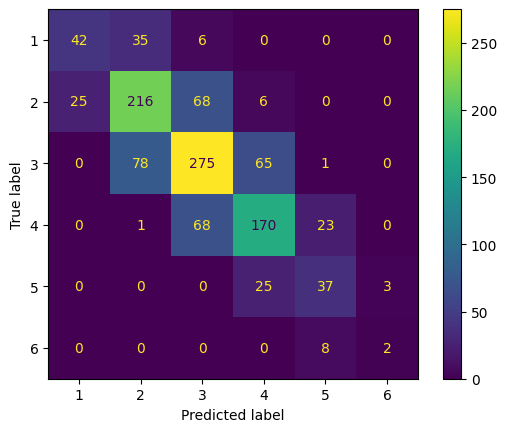

F1 score across fold: 0.6415848779807073
Cohen kappa score across fold: 0.8138885553660199
fold 2
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.74066	valid's QWK: 0.734999
[50]	train's QWK: 0.782827	valid's QWK: 0.769879
[75]	train's QWK: 0.801212	valid's QWK: 0.785325
[100]	train's QWK: 0.812491	valid's QWK: 0.794128
[125]	train's QWK: 0.82099	valid's QWK: 0.799574
[150]	train's QWK: 0.82891	valid's QWK: 0.804165
[175]	train's QWK: 0.835164	valid's QWK: 0.803526
[200]	train's QWK: 0.840809	valid's QWK: 0.802146
[225]	train's QWK: 0.846145	valid's QWK: 0.803524
Early stopping, best iteration is:
[162]	train's QWK: 0.831949	valid's QWK: 0.808259
Evaluated only: QWK


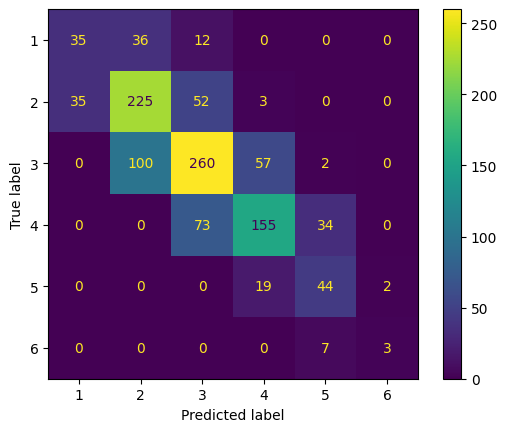

F1 score across fold: 0.6239641145498384
Cohen kappa score across fold: 0.8082590918191344
fold 3
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.742399	valid's QWK: 0.716031
[50]	train's QWK: 0.78493	valid's QWK: 0.754748
[75]	train's QWK: 0.804481	valid's QWK: 0.771592
[100]	train's QWK: 0.816277	valid's QWK: 0.77893
[125]	train's QWK: 0.824133	valid's QWK: 0.790806
[150]	train's QWK: 0.830144	valid's QWK: 0.795179
[175]	train's QWK: 0.836577	valid's QWK: 0.799446
[200]	train's QWK: 0.842216	valid's QWK: 0.798606
[225]	train's QWK: 0.847421	valid's QWK: 0.800354
[250]	train's QWK: 0.851979	valid's QWK: 0.796859
[275]	train's QWK: 0.855832	valid's QWK: 0.801797
[300]	train's QWK: 0.860442	valid's QWK: 0.803623
[325]	train's QWK: 0.863822	valid's QWK: 0.807803
[350]	train's QWK: 0.867626	valid's QWK: 0.807132
[375]	train's QWK: 0.870658	valid's QWK: 0.80863
[400]	train's QWK: 0.874512	valid's QWK: 

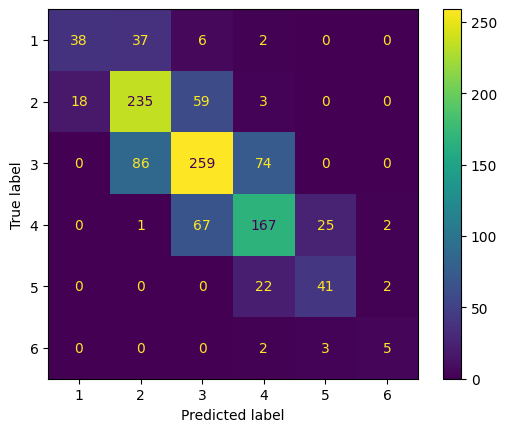

F1 score across fold: 0.6434325252991455
Cohen kappa score across fold: 0.8105721731415849
fold 4
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.741323	valid's QWK: 0.731492
[50]	train's QWK: 0.783136	valid's QWK: 0.7804
[75]	train's QWK: 0.802526	valid's QWK: 0.784062
[100]	train's QWK: 0.813979	valid's QWK: 0.788334
[125]	train's QWK: 0.822053	valid's QWK: 0.795601
[150]	train's QWK: 0.828856	valid's QWK: 0.796252
[175]	train's QWK: 0.836443	valid's QWK: 0.796709
[200]	train's QWK: 0.842393	valid's QWK: 0.797621
[225]	train's QWK: 0.847985	valid's QWK: 0.797163
[250]	train's QWK: 0.853265	valid's QWK: 0.795877
Early stopping, best iteration is:
[195]	train's QWK: 0.841253	valid's QWK: 0.80068
Evaluated only: QWK


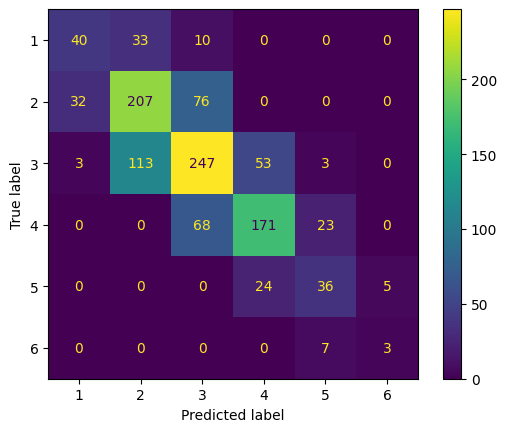

F1 score across fold: 0.6097267267661461
Cohen kappa score across fold: 0.8006796478150758
fold 5
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.742867	valid's QWK: 0.743998
[50]	train's QWK: 0.78621	valid's QWK: 0.783195
[75]	train's QWK: 0.803894	valid's QWK: 0.79215
[100]	train's QWK: 0.815439	valid's QWK: 0.798116
[125]	train's QWK: 0.823285	valid's QWK: 0.802818
[150]	train's QWK: 0.830121	valid's QWK: 0.798283
[175]	train's QWK: 0.837812	valid's QWK: 0.804979
[200]	train's QWK: 0.84254	valid's QWK: 0.801652
[225]	train's QWK: 0.848235	valid's QWK: 0.805976
[250]	train's QWK: 0.851633	valid's QWK: 0.806574
[275]	train's QWK: 0.855576	valid's QWK: 0.809203
[300]	train's QWK: 0.859864	valid's QWK: 0.80691
[325]	train's QWK: 0.863861	valid's QWK: 0.809515
[350]	train's QWK: 0.867965	valid's QWK: 0.810664
[375]	train's QWK: 0.871836	valid's QWK: 0.809884
[400]	train's QWK: 0.875243	valid's QWK: 0

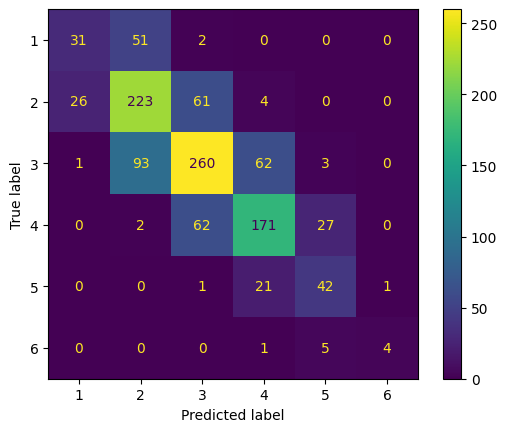

F1 score across fold: 0.6309753757712008
Cohen kappa score across fold: 0.8116701938364026
fold 6
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.744636	valid's QWK: 0.726649
[50]	train's QWK: 0.786915	valid's QWK: 0.769512
[75]	train's QWK: 0.802268	valid's QWK: 0.77409
[100]	train's QWK: 0.813452	valid's QWK: 0.77929
[125]	train's QWK: 0.822322	valid's QWK: 0.783421
[150]	train's QWK: 0.82774	valid's QWK: 0.800045
[175]	train's QWK: 0.833286	valid's QWK: 0.79371
[200]	train's QWK: 0.838945	valid's QWK: 0.800708
[225]	train's QWK: 0.844918	valid's QWK: 0.801385
[250]	train's QWK: 0.849298	valid's QWK: 0.800582
[275]	train's QWK: 0.853192	valid's QWK: 0.806202
[300]	train's QWK: 0.858197	valid's QWK: 0.805266
[325]	train's QWK: 0.862515	valid's QWK: 0.809502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	train's QWK: 0.865648	valid's QWK: 0.80947
[375]	train's QWK:

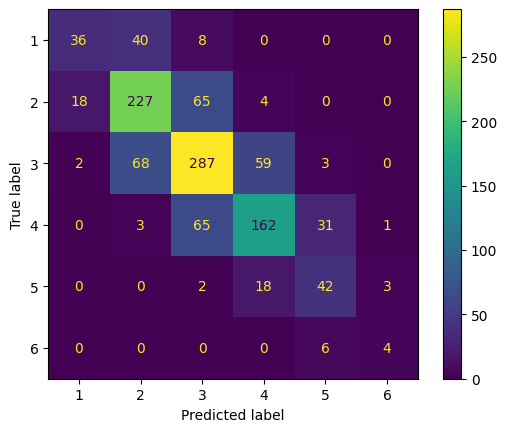

F1 score across fold: 0.6549502381983098
Cohen kappa score across fold: 0.8113608831774025
fold 7
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.740702	valid's QWK: 0.725525
[50]	train's QWK: 0.785063	valid's QWK: 0.762376
[75]	train's QWK: 0.803139	valid's QWK: 0.771083
[100]	train's QWK: 0.81392	valid's QWK: 0.777357
[125]	train's QWK: 0.822151	valid's QWK: 0.779361
[150]	train's QWK: 0.829996	valid's QWK: 0.78512
[175]	train's QWK: 0.837956	valid's QWK: 0.792818
[200]	train's QWK: 0.842565	valid's QWK: 0.796896
[225]	train's QWK: 0.847504	valid's QWK: 0.798467
[250]	train's QWK: 0.851014	valid's QWK: 0.798644
[275]	train's QWK: 0.855781	valid's QWK: 0.798666
[300]	train's QWK: 0.860501	valid's QWK: 0.799965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[236]	train's QWK: 0.848998	valid's QWK: 0.802615
Evaluated only: QWK


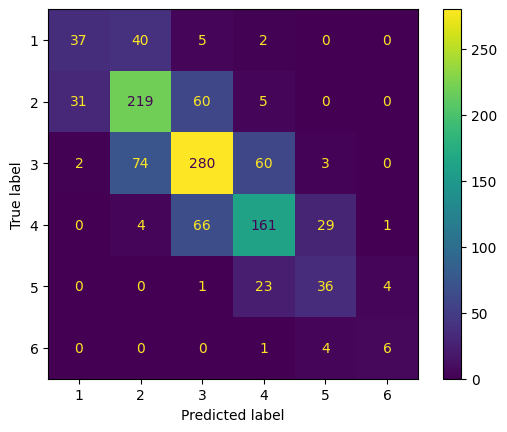

F1 score across fold: 0.6395490331435274
Cohen kappa score across fold: 0.8026152860288414
fold 8
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.744184	valid's QWK: 0.72711
[50]	train's QWK: 0.784565	valid's QWK: 0.759695
[75]	train's QWK: 0.803934	valid's QWK: 0.76928
[100]	train's QWK: 0.81475	valid's QWK: 0.779643
[125]	train's QWK: 0.822664	valid's QWK: 0.784329
[150]	train's QWK: 0.829062	valid's QWK: 0.784901
[175]	train's QWK: 0.835415	valid's QWK: 0.790499
[200]	train's QWK: 0.841373	valid's QWK: 0.789872
[225]	train's QWK: 0.846232	valid's QWK: 0.788824
[250]	train's QWK: 0.852032	valid's QWK: 0.788947
Early stopping, best iteration is:
[181]	train's QWK: 0.8368	valid's QWK: 0.791962
Evaluated only: QWK


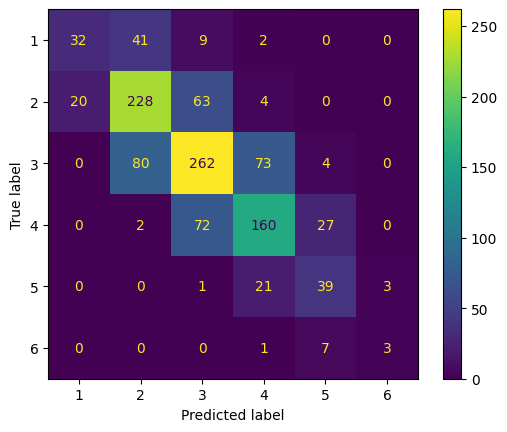

F1 score across fold: 0.6241750356154443
Cohen kappa score across fold: 0.7919624914378164
fold 9
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.745646	valid's QWK: 0.718445
[50]	train's QWK: 0.784743	valid's QWK: 0.75786
[75]	train's QWK: 0.804307	valid's QWK: 0.77931
[100]	train's QWK: 0.815174	valid's QWK: 0.78715
[125]	train's QWK: 0.822386	valid's QWK: 0.793104
[150]	train's QWK: 0.828995	valid's QWK: 0.797018
[175]	train's QWK: 0.834414	valid's QWK: 0.801589
[200]	train's QWK: 0.84062	valid's QWK: 0.802171
[225]	train's QWK: 0.845796	valid's QWK: 0.80042
[250]	train's QWK: 0.85113	valid's QWK: 0.802294
[275]	train's QWK: 0.855667	valid's QWK: 0.80291
Early stopping, best iteration is:
[216]	train's QWK: 0.844776	valid's QWK: 0.803582
Evaluated only: QWK


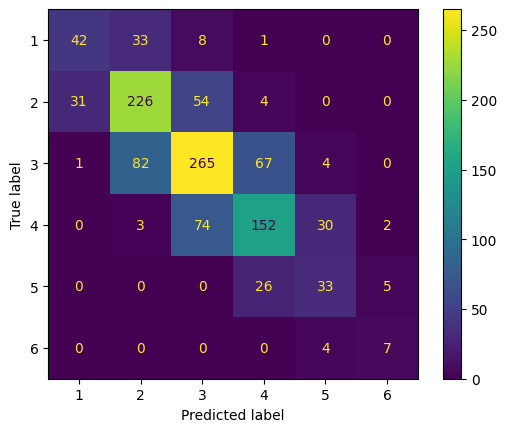

F1 score across fold: 0.6276003758993778
Cohen kappa score across fold: 0.8035822447028027
fold 10
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.743333	valid's QWK: 0.722439
[50]	train's QWK: 0.787471	valid's QWK: 0.760363
[75]	train's QWK: 0.805631	valid's QWK: 0.776178
[100]	train's QWK: 0.816196	valid's QWK: 0.783864
[125]	train's QWK: 0.824713	valid's QWK: 0.788459
[150]	train's QWK: 0.831517	valid's QWK: 0.794161
[175]	train's QWK: 0.837739	valid's QWK: 0.795921
[200]	train's QWK: 0.843568	valid's QWK: 0.798545
[225]	train's QWK: 0.847378	valid's QWK: 0.798361
[250]	train's QWK: 0.851071	valid's QWK: 0.802731
[275]	train's QWK: 0.855126	valid's QWK: 0.802593
[300]	train's QWK: 0.859114	valid's QWK: 0.803057
[325]	train's QWK: 0.862746	valid's QWK: 0.805445
[350]	train's QWK: 0.866432	valid's QWK: 0.803704
[375]	train's QWK: 0.870793	valid's QWK: 0.804783
Early stopping, best iteration is:
[3

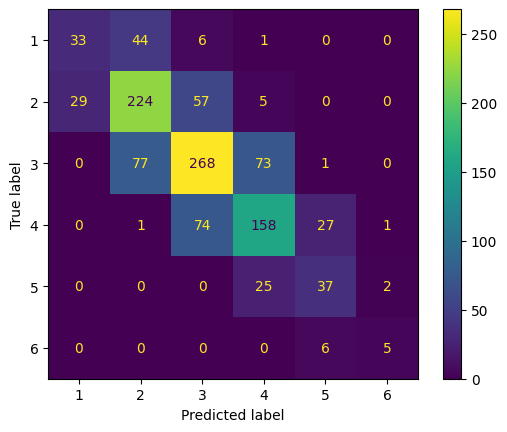

F1 score across fold: 0.6261607952388459
Cohen kappa score across fold: 0.8064302177934068
fold 11
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.742468	valid's QWK: 0.748453
[50]	train's QWK: 0.785037	valid's QWK: 0.786447
[75]	train's QWK: 0.804728	valid's QWK: 0.789811
[100]	train's QWK: 0.816343	valid's QWK: 0.791686
[125]	train's QWK: 0.824487	valid's QWK: 0.795732
[150]	train's QWK: 0.830402	valid's QWK: 0.796353
[175]	train's QWK: 0.836914	valid's QWK: 0.798642
[200]	train's QWK: 0.842018	valid's QWK: 0.802161
[225]	train's QWK: 0.847381	valid's QWK: 0.800911
[250]	train's QWK: 0.85195	valid's QWK: 0.803508
[275]	train's QWK: 0.855848	valid's QWK: 0.802417
[300]	train's QWK: 0.859645	valid's QWK: 0.805051
[325]	train's QWK: 0.863645	valid's QWK: 0.806194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	train's QWK: 0.868168	valid's QWK: 0.807613
[375]	train's

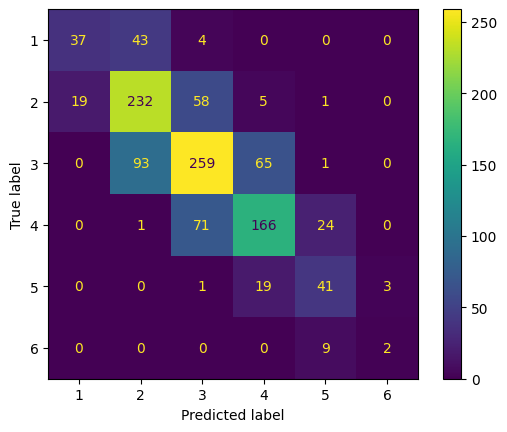

F1 score across fold: 0.6356598591195529
Cohen kappa score across fold: 0.8125151099724056
fold 12
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.743988	valid's QWK: 0.728046
[50]	train's QWK: 0.783449	valid's QWK: 0.770414
[75]	train's QWK: 0.801531	valid's QWK: 0.781666
[100]	train's QWK: 0.811405	valid's QWK: 0.788949
[125]	train's QWK: 0.821528	valid's QWK: 0.793049
[150]	train's QWK: 0.827973	valid's QWK: 0.793114
[175]	train's QWK: 0.834449	valid's QWK: 0.796915
[200]	train's QWK: 0.840377	valid's QWK: 0.801862
[225]	train's QWK: 0.845961	valid's QWK: 0.803342
[250]	train's QWK: 0.850841	valid's QWK: 0.802929
[275]	train's QWK: 0.853946	valid's QWK: 0.801127
Early stopping, best iteration is:
[207]	train's QWK: 0.842025	valid's QWK: 0.804155
Evaluated only: QWK


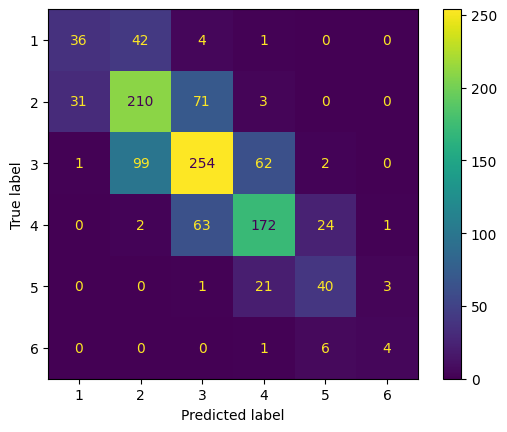

F1 score across fold: 0.6193298769656701
Cohen kappa score across fold: 0.8041546124147562
fold 13
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.740512	valid's QWK: 0.739367
[50]	train's QWK: 0.786615	valid's QWK: 0.776378
[75]	train's QWK: 0.802513	valid's QWK: 0.787616
[100]	train's QWK: 0.813337	valid's QWK: 0.793132
[125]	train's QWK: 0.822641	valid's QWK: 0.791755
[150]	train's QWK: 0.830654	valid's QWK: 0.797702
[175]	train's QWK: 0.837559	valid's QWK: 0.79848
[200]	train's QWK: 0.842239	valid's QWK: 0.80099
[225]	train's QWK: 0.847263	valid's QWK: 0.800087
[250]	train's QWK: 0.851562	valid's QWK: 0.803541
[275]	train's QWK: 0.856254	valid's QWK: 0.805035
[300]	train's QWK: 0.86034	valid's QWK: 0.804677
[325]	train's QWK: 0.864193	valid's QWK: 0.801184
Early stopping, best iteration is:
[268]	train's QWK: 0.854976	valid's QWK: 0.805035
Evaluated only: QWK


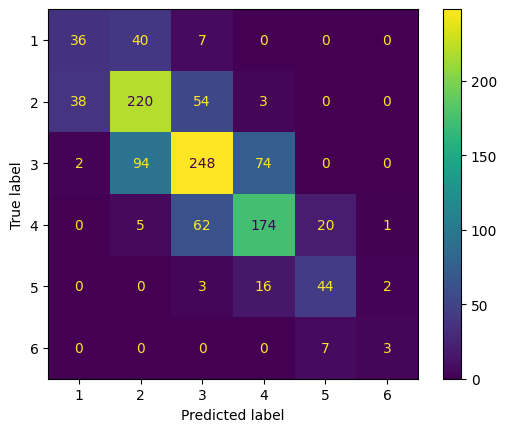

F1 score across fold: 0.6272028418794815
Cohen kappa score across fold: 0.8050351979650923
fold 14
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.73953	valid's QWK: 0.745702
[50]	train's QWK: 0.784109	valid's QWK: 0.77783
[75]	train's QWK: 0.802861	valid's QWK: 0.791573
[100]	train's QWK: 0.814537	valid's QWK: 0.7992
[125]	train's QWK: 0.822555	valid's QWK: 0.804851
[150]	train's QWK: 0.829476	valid's QWK: 0.806691
[175]	train's QWK: 0.835559	valid's QWK: 0.807802
[200]	train's QWK: 0.840504	valid's QWK: 0.810121
[225]	train's QWK: 0.844672	valid's QWK: 0.811408
[250]	train's QWK: 0.849498	valid's QWK: 0.810915
[275]	train's QWK: 0.854133	valid's QWK: 0.811468
Early stopping, best iteration is:
[209]	train's QWK: 0.841607	valid's QWK: 0.81375
Evaluated only: QWK


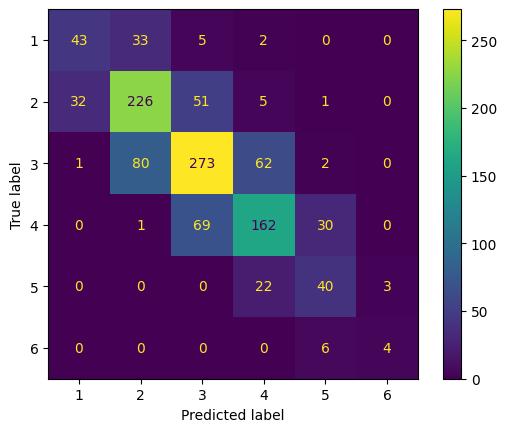

F1 score across fold: 0.6484010108051507
Cohen kappa score across fold: 0.8137500321526867
fold 15
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.742781	valid's QWK: 0.763394
[50]	train's QWK: 0.787089	valid's QWK: 0.793142
[75]	train's QWK: 0.804308	valid's QWK: 0.80395
[100]	train's QWK: 0.815033	valid's QWK: 0.803932
[125]	train's QWK: 0.824009	valid's QWK: 0.806557
[150]	train's QWK: 0.831066	valid's QWK: 0.809133
[175]	train's QWK: 0.836718	valid's QWK: 0.810038
[200]	train's QWK: 0.841649	valid's QWK: 0.813975
[225]	train's QWK: 0.84563	valid's QWK: 0.808968
[250]	train's QWK: 0.849263	valid's QWK: 0.810374
[275]	train's QWK: 0.853691	valid's QWK: 0.811641
Early stopping, best iteration is:
[203]	train's QWK: 0.842042	valid's QWK: 0.814285
Evaluated only: QWK


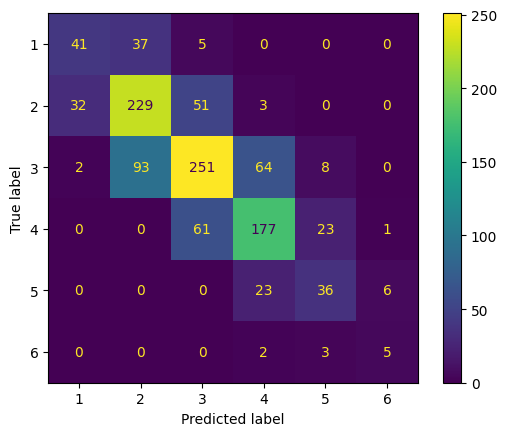

F1 score across fold: 0.6400451894790344
Cohen kappa score across fold: 0.8142848893927007
Mean F1 score across 15 folds: 0.6328505251140955
Mean Cohen kappa score across 15 folds: 0.8073840418010751


In [13]:
# Define the number of splits for cross-validation
if debug:
    n_splits = 5
else:
    n_splits = 15
    
# Initialize StratifiedKFold with the specified number of splits
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Lists to store scores
f1_scores = []
kappa_scores = []
models_with_tfidf = []
predictions = []
callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]
# Loop through each fold of the cross-validation
i=1
for train_index, test_index in skf.split(X, y_split):
    # Split the data into training and testing sets for this fold
    print('fold',i)
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]
    
    # transform
    X_train_fold = vectorizar_trans.fit_transform(X_train_fold)
    X_test_fold = vectorizar_trans.transform(X_test_fold)
    
    
    
    # the pipeline have an issue may look at it later
    # Fit the model on the training data for this fold
    predictor = model.fit(X_train_fold,
                                  y_train_fold,
                                  eval_names=['train', 'valid'],
                                  eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                  eval_metric=quadratic_weighted_kappa,
                                  callbacks=callbacks,)

    models_with_tfidf.append((vectorizar_trans,predictor))
    
    # Make predictions on the test data for this fold
    predictions_fold = predictor.predict(X_test_fold)
    predictions_fold = predictions_fold + a
    predictions_fold = predictions_fold.clip(1, 6).round()
    predictions.append(predictions_fold)
    # Calculate and store the F1 score for this fold
    f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
    f1_scores.append(f1_fold)
    
    # Calculate and store the Cohen's kappa score for this fold
    kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
    kappa_scores.append(kappa_fold)
    
    # Calculating the confusion matrix
    cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

    # Displaying the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[x for x in range(1,7)])
    disp.plot()
    plt.show()
    print(f'F1 score across fold: {f1_fold}')
    print(f'Cohen kappa score across fold: {kappa_fold}')
    i+=1
# Calculate the mean scores across all folds
mean_f1_score = np.mean(f1_scores)
mean_kappa_score = np.mean(kappa_scores)

# Print the mean scores
print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

# **Inference**

In [14]:
test

essay_id,full_text,paragraph
str,str,list[str]
"""000d118""","""Many people ha…","[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"
"""000fe60""","""I am a scienti…","[""I am a scientist at NASA that is discussing the ""face"" on mars. I will be explaining how the ""face"" is a land form. By sharing my information about this isue i will tell you just that."", ""First off, how could it be a martions drawing. There is no plant life on mars as of rite now that we know of, which means so far as we know it is not possible for any type of life. That explains how it could not be made by martians. Also why and how would a martion build a face so big. It just does not make any since that a martian did this."", … ""To sum all this up the ""face"" on mars is a landform but others would like to beleive it's a martian sculpture. Which every one that works at NASA says it's a landform and they are all the ones working on the planet and taking pictures.""]"
"""001ab80""","""People always …","[""People always wish they had the same technology that they have seen in movies, or the best new piece of technology that is all over social media. However, nobody seems to think of the risks that these kinds of new technologies may have. Cars have been around for many decades, and now manufacturers are starting to get on the bandwagon and come up with the new and 

In [15]:
# Paragraph
tmp = Paragraph_Preprocess(test)
test_feats = Paragraph_Eng(tmp)
# Sentence
tmp = Sentence_Preprocess(test)
test_feats = test_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
# Word
tmp = Word_Preprocess(test)
test_feats = test_feats.merge(Word_Eng(tmp), on='essay_id', how='left')
test_feats = test_feats.merge(test[['essay_id','full_text']].to_pandas(), on='essay_id')
# Tfidf
#test_tfid = vectorizer.transform([i for i in test['full_text']])
#dense_matrix = test_tfid.toarray()
#df = pd.DataFrame(dense_matrix)
#tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
#df.columns = tfid_columns
#df['essay_id'] = test_feats['essay_id']
#test_feats = test_feats.merge(df, on='essay_id', how='left')
# Features number
#feature_names = list(filter(lambda x: x not in ['essay_id','score'], test_feats.columns))
#print('Features number: ',len(feature_names))
test_feats.head(3)

,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3,full_text
0,000d118,1,1,1,1,1,1,1,1,1,...,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0,Many people have car where they live. The thin...
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0,I am a scientist at NASA that is discussing th...
2,001ab80,4,4,4,4,4,4,4,4,4,...,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0,People always wish they had the same technolog...


In [16]:
probabilities = []
for pipe in models_with_tfidf:
    test_transformed = pipe[0].transform(test_feats)
    proba= pipe[1].predict(test_transformed)+ a
    probabilities.append(proba)
# Compute the average probabilities across all models
predictions = np.mean(probabilities, axis=0)

predictions = np.round(predictions.clip(1, 6))

# Print the predictions
print(predictions)

[2. 3. 5.]


In [17]:
submission=pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")
submission['score']=predictions
submission['score']=submission['score'].astype(int)
submission.to_csv("submission.csv",index=None)
display(submission.head())

,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,5
